In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.manifold import TSNE
from sklearn.metrics import roc_curve, f1_score, precision_score, recall_score, mean_squared_error
from sklearn.preprocessing import LabelBinarizer

from source import read_preprocessed_data
from transform import load_process_and_store_spreadsheets
from pipelines import benchmark_pipelines, build_classifier_pipelines, build_regression_pipelines

RANDOM_STATE = 1234

In [3]:
allele_columns = ["T0: Allele \nFraction", "T1: Allele Fraction"]
# allele_columns = [
#     "T0: No. Mutant \nMolecules per mL",
#     "T1: No. Mutant \nMolecules per mL",
# ]
# 
load_process_and_store_spreadsheets(allele_columns=allele_columns, transformation=lambda x, y: y*x/(x+y))
# load_process_and_store_spreadsheets(allele_columns=allele_columns, transformation=lambda x, y: (y-x)/x)
# load_process_and_store_spreadsheets(allele_columns=allele_columns, transformation=lambda x, y: (y-x))

X_train, y_train = read_preprocessed_data("output/train.tsv")
X_test, y_test = read_preprocessed_data("output/test.tsv")

## Classification

In [4]:
y_train_resp = y_train["response_grouped"] == 'responder (pr+cr)'
y_test_resp = y_test["response_grouped"] == 'responder (pr+cr)'

In [5]:
ps_class = build_classifier_pipelines()

In [6]:
b = benchmark_pipelines(
    ps_class, X_train, y_train_resp, X_test, y_test_resp, metric=f1_score,
)
b

,Richard_test,Julian_test,Lev_test,Freeman_test
DecisionTreeClassifier,0.125000,0.620690,0.166667,0.125000
RandomForestClassifier,0.285714,0.533333,0.181818,0.222222
GradientBoostingClassifier,0.000000,0.000000,0.000000,0.000000
KNeighborsClassifier,0.400000,0.315789,0.181818,0.352941
LogisticRegression,0.526316,0.382979,0.526316,0.526316
SVC,0.000000,0.000000,0.000000,0.000000
DummyClassifier,0.000000,0.000000,0.000000,0.000000


In [7]:
print(b.mean(axis=0))
print('--'*10)
print(b.mean(axis=1))

Richard_test    0.191004
Julian_test     0.264684
Lev_test        0.150946
Freeman_test    0.175211
dtype: float64
--------------------
DecisionTreeClassifier        0.259339
RandomForestClassifier        0.305772
GradientBoostingClassifier    0.000000
KNeighborsClassifier          0.312637
LogisticRegression            0.490482
SVC                           0.000000
DummyClassifier               0.000000
dtype: float64


In [8]:
p_win = ps_class['DecisionTreeClassifier']['Julian']

In [9]:
from views import plot_confusion_matrix
plot_confusion_matrix(y_test_resp, p_win.predict(X_test), classes=y_test_resp.unique())

Confusion matrix, without normalization
[[18 11]
 [ 0  9]]


In [10]:
recall = benchmark_pipelines(
    ps_class, X_train, y_train_resp, X_test, y_test_resp, metric=recall_score,
)
recall

,Richard_test,Julian_test,Lev_test,Freeman_test
DecisionTreeClassifier,0.111111,1.000000,0.111111,0.111111
RandomForestClassifier,0.222222,0.888889,0.111111,0.222222
GradientBoostingClassifier,0.000000,0.000000,0.000000,0.000000
KNeighborsClassifier,0.333333,0.333333,0.111111,0.333333
LogisticRegression,0.555556,1.000000,0.555556,0.555556
SVC,0.000000,0.000000,0.000000,0.000000
DummyClassifier,0.000000,0.000000,0.000000,0.000000


Confusion matrix, without normalization
[[24  5]
 [ 4  5]]


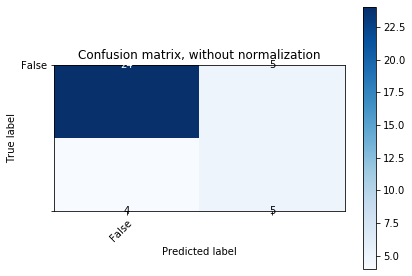

In [11]:
from views import plot_confusion_matrix
plot_confusion_matrix(y_test_resp, ps_class['LogisticRegression']['Lev'].predict(X_test), classes=y_test_resp.unique())

## Dimensional representation

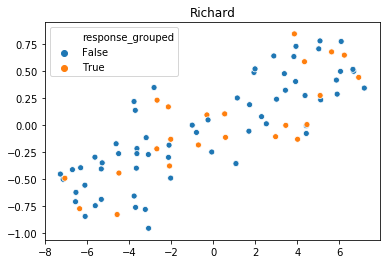

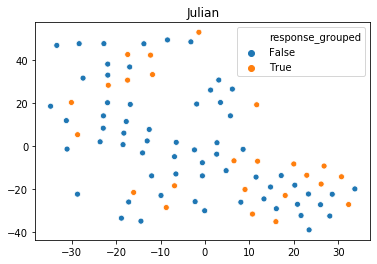

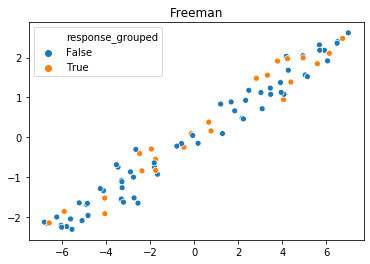

In [12]:
from views import view_pipelines

view_pipelines(ps_class['LogisticRegression'], X_train, y_train_resp, random_state=RANDOM_STATE)

## Regression

In [38]:
y_train_os = y_train['OS_days']
y_train_pfs = y_train['PFS_days']

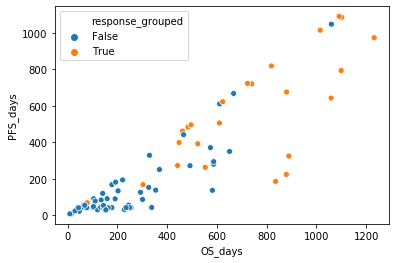

In [39]:
sns.scatterplot(x=y_train_os, y=y_train_pfs, hue=y_train_resp)

### Overall survival (OS)

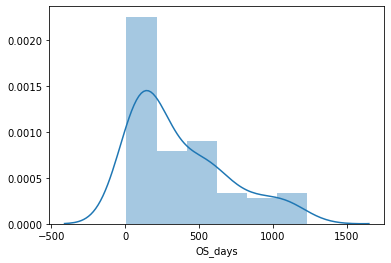

In [25]:
import seaborn as sns
sns.distplot(y_train_os)

In [26]:
ps = build_regression_pipelines()
b = benchmark_pipelines(ps, X_train, y_train_os, X_test, y_test_os, metric=mean_squared_error)
# Root mean squared error.
b = b**0.5

In [27]:
print(b.mean(axis=0))
print('--'*10)
print(b.mean(axis=1))

Richard_test    316.799757
Julian_test     273.258122
Lev_test        285.578584
Freeman_test    638.191486
dtype: float64
--------------------
DecisionTreeRegressor        314.279185
RandomForestRegressor        305.809359
GradientBoostingRegressor    293.900891
KNeighborsRegressor          332.909133
ElasticNet                   270.817548
LinearRegression             956.175452
SVR                          276.691522
DummyRegressor               277.072810
dtype: float64


In [28]:
b

,Richard_test,Julian_test,Lev_test,Freeman_test
DecisionTreeRegressor,376.021202,255.227153,300.798164,325.070220
RandomForestRegressor,343.277793,289.205408,305.080527,285.673707
GradientBoostingRegressor,316.987848,266.030076,285.730396,306.855242
KNeighborsRegressor,369.776634,289.899266,310.046687,361.913946
ElasticNet,271.507413,271.744500,268.480957,271.537322
LinearRegression,302.710133,260.780187,260.847317,3000.364169
SVR,277.044226,276.105578,276.571812,277.044472
DummyRegressor,277.072810,277.072810,277.072810,277.072810


## Progression Free Survival (PFS)

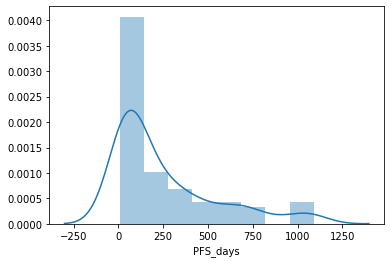

In [29]:
y_train_pfs = y_train['PFS_days']
y_test_pfs = y_test['PFS_days']
sns.distplot(y_train_pfs)

In [30]:
ps = build_regression_pipelines()
b = benchmark_pipelines(ps, X_train, y_train_pfs, X_test, y_test_pfs, metric=mean_squared_error)
# Root mean squared error.
b = b**0.5

In [31]:
print(b.mean(axis=0))
print('--'*10)
print(b.mean(axis=1))

Richard_test    311.473587
Julian_test     293.137569
Lev_test        293.423473
Freeman_test    384.899778
dtype: float64
--------------------
DecisionTreeRegressor        322.459104
RandomForestRegressor        290.494692
GradientBoostingRegressor    292.074357
KNeighborsRegressor          331.990772
ElasticNet                   278.750185
LinearRegression             452.765383
SVR                          298.611781
DummyRegressor               298.722543
dtype: float64


In [32]:
b

,Richard_test,Julian_test,Lev_test,Freeman_test
DecisionTreeRegressor,361.213276,272.840127,305.447406,350.335608
RandomForestRegressor,291.047843,293.009093,281.791057,296.130773
GradientBoostingRegressor,307.619806,283.096726,291.983611,285.597283
KNeighborsRegressor,353.867007,320.053519,317.456525,336.586037
ElasticNet,273.793199,288.689546,278.712128,273.805864
LinearRegression,306.814569,290.240609,274.696610,939.309743
SVR,298.710452,298.448391,298.577905,298.710375
DummyRegressor,298.722543,298.722543,298.722543,298.722543


## Multitask model


In [33]:
from sklearn.linear_model import MultiTaskElasticNet
from pipelines import pipelines
ps = pipelines(MultiTaskElasticNet, VotingEstimator=None)

In [34]:
Y_train = y_train[['OS_days', 'PFS_days']]
Y_test = y_test[['OS_days', 'PFS_days']]
rmse = lambda a, b: mean_squared_error(a, b, multioutput='raw_values')**0.5
benchmark_pipelines({'bla': ps}, X_train, Y_train, X_test, Y_test, metric=rmse)
# p = ps['Richard']
# p.fit(X_train, Y_train)

,Freeman_test,Julian_test,Richard_test
bla,"[268.42224374066984, 273.7039715426234]","[271.7399772705852, 288.69028307704565]","[268.40506641346275, 273.6944998454938]"
